In [1]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(6447) #replaced 1234 with my emailID number
tf.random.set_seed(6447) #replaced 1234 with my emailID number

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28


In [5]:
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

In [6]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

**Case 1:**

Using default batch size without softmax activation in output layer, without any regularization to determine the Categorical Cross-Entropy of test dataset and determine the accuracy of default model in GPU,TPU,CPU and on default mode.

In [7]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    #output = tf.nn.softmax(output)
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


Train Accuracy: 0.9234
Number of Epoch = 1 - Average Cross Entropy:= 0.00393859130859375 

Validation Accuracy: 0.9305

Train Accuracy: 0.9412
Number of Epoch = 2 - Average Cross Entropy:= 0.0016870408630371093 

Validation Accuracy: 0.9438

Train Accuracy: 0.9578
Number of Epoch = 3 - Average Cross Entropy:= 0.0012424580383300781 

Validation Accuracy: 0.9548

Train Accuracy: 0.9650
Number of Epoch = 4 - Average Cross Entropy:= 0.0009818502807617188 

Validation Accuracy: 0.9598

Train Accuracy: 0.9676
Number of Epoch = 5 - Average Cross Entropy:= 0.0008192736053466797 

Validation Accuracy: 0.9608

Train Accuracy: 0.9741
Number of Epoch = 6 - Average Cross Entropy:= 0.0007009522247314453 

Validation Accuracy: 0.9653

Train Accuracy: 0.9749
Number of Epoch = 7 - Average Cross Entropy:= 0.0005963068008422852 

Validation Accuracy: 0.9650

Train Accuracy: 0.9803
Number of Epoch = 8 - Average Cross Entropy:= 0.0005219042205810547 

Validation Accuracy: 0.9678

Train Accuracy: 0.9833
Nu

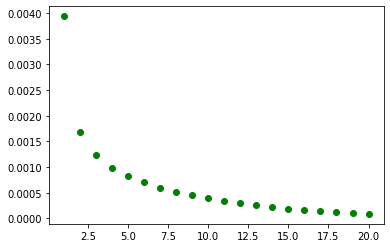

In [8]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs



Train Accuracy: 0.9188
Number of Epoch = 1 - Average Cross Entropy:= 0.0039001004028320313 

Validation Accuracy: 0.9245

Train Accuracy: 0.9469
Number of Epoch = 2 - Average Cross Entropy:= 0.0016829531860351563 

Validation Accuracy: 0.9495

Train Accuracy: 0.9602
Number of Epoch = 3 - Average Cross Entropy:= 0.0012488506317138671 

Validation Accuracy: 0.9589

Train Accuracy: 0.9688
Number of Epoch = 4 - Average Cross Entropy:= 0.0009958902740478516 

Validation Accuracy: 0.9639

Train Accuracy: 0.9742
Number of Epoch = 5 - Average Cross Entropy:= 0.000830152816772461 

Validation Accuracy: 0.9670

Train Accuracy: 0.9777
Number of Epoch = 6 - Average Cross Entropy:= 0.000711906509399414 

Validation Accuracy: 0.9683

Train Accuracy: 0.9796
Number of Epoch = 7 - Average Cross Entropy:= 0.0006042739868164063 

Validation Accuracy: 0.9684

Train Accuracy: 0.9829
Number of Epoch = 8 - Average Cross Entropy:= 0.0005247521591186524 

Validation Accuracy: 0.9706

Train Accuracy: 0.9857
Nu

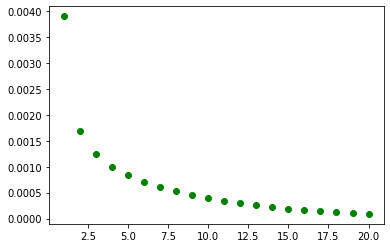

In [9]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_gpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_gpu.forward(inputs) 
    loss_total = loss_total + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)

  preds = mlp_on_gpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_gpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs



Train Accuracy: 0.9221
Number of Epoch = 1 - Average Cross Entropy:= 0.003832458801269531 

Validation Accuracy: 0.9332

Train Accuracy: 0.9446
Number of Epoch = 2 - Average Cross Entropy:= 0.0016711297607421875 

Validation Accuracy: 0.9486

Train Accuracy: 0.9575
Number of Epoch = 3 - Average Cross Entropy:= 0.001253113784790039 

Validation Accuracy: 0.9577

Train Accuracy: 0.9648
Number of Epoch = 4 - Average Cross Entropy:= 0.0009997321319580078 

Validation Accuracy: 0.9622

Train Accuracy: 0.9698
Number of Epoch = 5 - Average Cross Entropy:= 0.0008400882720947265 

Validation Accuracy: 0.9638

Train Accuracy: 0.9752
Number of Epoch = 6 - Average Cross Entropy:= 0.000712779541015625 

Validation Accuracy: 0.9666

Train Accuracy: 0.9744
Number of Epoch = 7 - Average Cross Entropy:= 0.0006105321884155273 

Validation Accuracy: 0.9662

Train Accuracy: 0.9792
Number of Epoch = 8 - Average Cross Entropy:= 0.0005335707473754882 

Validation Accuracy: 0.9677

Train Accuracy: 0.9793
Num

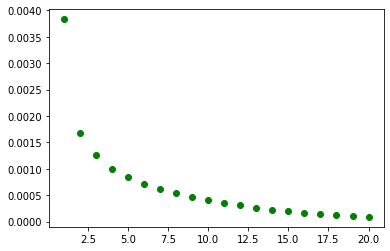

In [10]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_tpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='tpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_tpu.forward(inputs) 
    loss_total = loss_total + mlp_on_tpu.loss(preds, outputs)
    lt = lt + mlp_on_tpu.loss(preds, outputs)
    mlp_on_tpu.backward(inputs, outputs)

  preds = mlp_on_tpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_tpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs



Train Accuracy: 0.9171
Number of Epoch = 1 - Average Cross Entropy:= 0.003797075500488281 

Validation Accuracy: 0.9294

Train Accuracy: 0.9369
Number of Epoch = 2 - Average Cross Entropy:= 0.0016630039978027345 

Validation Accuracy: 0.9417

Train Accuracy: 0.9585
Number of Epoch = 3 - Average Cross Entropy:= 0.0012318392944335938 

Validation Accuracy: 0.9575

Train Accuracy: 0.9649
Number of Epoch = 4 - Average Cross Entropy:= 0.0009813417053222656 

Validation Accuracy: 0.9622

Train Accuracy: 0.9717
Number of Epoch = 5 - Average Cross Entropy:= 0.0008163775634765625 

Validation Accuracy: 0.9667

Train Accuracy: 0.9764
Number of Epoch = 6 - Average Cross Entropy:= 0.0006954207611083984 

Validation Accuracy: 0.9695

Train Accuracy: 0.9787
Number of Epoch = 7 - Average Cross Entropy:= 0.0005846036529541015 

Validation Accuracy: 0.9694

Train Accuracy: 0.9816
Number of Epoch = 8 - Average Cross Entropy:= 0.0005121396255493164 

Validation Accuracy: 0.9701

Train Accuracy: 0.9841
N

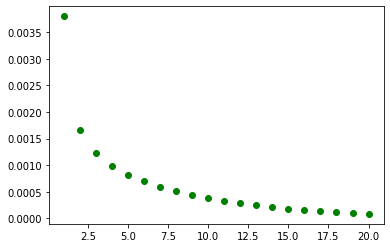

In [11]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs



Train Accuracy: 0.9269
Number of Epoch = 1 - Average Cross Entropy:= 0.00384845458984375 

Validation Accuracy: 0.9343

Train Accuracy: 0.9357
Number of Epoch = 2 - Average Cross Entropy:= 0.001679119873046875 

Validation Accuracy: 0.9419

Train Accuracy: 0.9562
Number of Epoch = 3 - Average Cross Entropy:= 0.0012357581329345702 

Validation Accuracy: 0.9551

Train Accuracy: 0.9588
Number of Epoch = 4 - Average Cross Entropy:= 0.0009752535247802734 

Validation Accuracy: 0.9564

Train Accuracy: 0.9680
Number of Epoch = 5 - Average Cross Entropy:= 0.0008210462188720703 

Validation Accuracy: 0.9620

Train Accuracy: 0.9726
Number of Epoch = 6 - Average Cross Entropy:= 0.0006989602661132812 

Validation Accuracy: 0.9657

Train Accuracy: 0.9737
Number of Epoch = 7 - Average Cross Entropy:= 0.0005962605667114258 

Validation Accuracy: 0.9654

Train Accuracy: 0.9792
Number of Epoch = 8 - Average Cross Entropy:= 0.0005209699249267578 

Validation Accuracy: 0.9680

Train Accuracy: 0.9810
Num

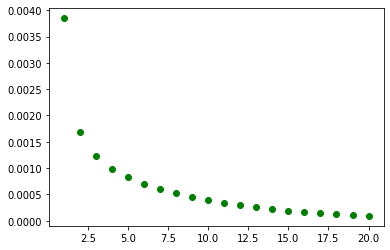

In [12]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_default = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output)

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_default.forward(inputs) 
    loss_total = loss_total + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)

  preds = mlp_on_default.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_default.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [13]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0249

Test Accuracy: 0.97


In [14]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_gpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_gpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_gpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0251

Test Accuracy: 0.97


In [15]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_tpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_tpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_tpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0262

Test Accuracy: 0.97


In [16]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_default.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0273

Test Accuracy: 0.97


**Case 2:**

Change Batch Size(HyperParameter Optimization) and try to regularize the objective function by applying Dropout penalty/regularization. Since the codebase is huge because of the model running in different config, I am only going to implement the mlp on cpu function and not mlp on other modes.

In [17]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.dlayer1, self.dlayer2, self.dlayer3, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, tf.keras.layers.Dropout(rate=0.2), tf.keras.layers.Dropout(rate=0.2), tf.keras.layers.Dropout(rate=0.2), device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    h1 = self.dlayer1(h1)

    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    h2 = self.dlayer2(h2)

    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)
    h3 = self.dlayer3(h3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    #output = tf.nn.softmax(output)
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


Train Accuracy: 0.9200
Number of Epoch = 1 - Average Cross Entropy:= 0.0037928497314453124 

Validation Accuracy: 0.9271

Train Accuracy: 0.9431
Number of Epoch = 2 - Average Cross Entropy:= 0.0016540782165527343 

Validation Accuracy: 0.9463

Train Accuracy: 0.9596
Number of Epoch = 3 - Average Cross Entropy:= 0.0012394468688964844 

Validation Accuracy: 0.9589

Train Accuracy: 0.9645
Number of Epoch = 4 - Average Cross Entropy:= 0.0009917610931396484 

Validation Accuracy: 0.9608

Train Accuracy: 0.9709
Number of Epoch = 5 - Average Cross Entropy:= 0.0008350493621826172 

Validation Accuracy: 0.9656

Train Accuracy: 0.9745
Number of Epoch = 6 - Average Cross Entropy:= 0.0007147328186035156 

Validation Accuracy: 0.9675

Train Accuracy: 0.9767
Number of Epoch = 7 - Average Cross Entropy:= 0.0006069582366943359 

Validation Accuracy: 0.9681

Train Accuracy: 0.9806
Number of Epoch = 8 - Average Cross Entropy:= 0.0005323690795898437 

Validation Accuracy: 0.9690

Train Accuracy: 0.9830


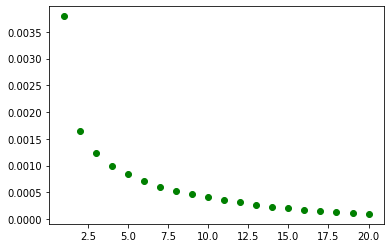

In [18]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [19]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0251

Test Accuracy: 0.97


**Case 3:**

Change Batch Size(HyperParameter Optimization) and try to regularize the objective function by applying l1 penalty/regularization. Since the codebase is huge because of the model running in different config, I am only going to implement the mlp on cpu function and not mlp on other modes.

In [20]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      L1 = (tf.reduce_sum(tf.math.abs(self.W1))+ tf.reduce_sum(tf.math.abs(self.W2))+tf.reduce_sum(tf.math.abs(self.W3)) + tf.reduce_sum(tf.math.abs(self.W4)))
      current_loss = self.loss(predicted, y_train) + 0.001 * L1
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    #output = tf.nn.softmax(output)
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


Train Accuracy: 0.9102
Number of Epoch = 1 - Average Cross Entropy:= 0.004244842834472656 

Validation Accuracy: 0.9199

Train Accuracy: 0.8939
Number of Epoch = 2 - Average Cross Entropy:= 0.0023888348388671874 

Validation Accuracy: 0.9051

Train Accuracy: 0.8947
Number of Epoch = 3 - Average Cross Entropy:= 0.002361602020263672 

Validation Accuracy: 0.9050

Train Accuracy: 0.9027
Number of Epoch = 4 - Average Cross Entropy:= 0.0023913768005371094 

Validation Accuracy: 0.9145

Train Accuracy: 0.9280
Number of Epoch = 5 - Average Cross Entropy:= 0.0023613333129882813 

Validation Accuracy: 0.9360

Train Accuracy: 0.9062
Number of Epoch = 6 - Average Cross Entropy:= 0.002252071990966797 

Validation Accuracy: 0.9146

Train Accuracy: 0.9146
Number of Epoch = 7 - Average Cross Entropy:= 0.0021241474914550783 

Validation Accuracy: 0.9209

Train Accuracy: 0.9261
Number of Epoch = 8 - Average Cross Entropy:= 0.0020736181640625 

Validation Accuracy: 0.9356

Train Accuracy: 0.9347
Number

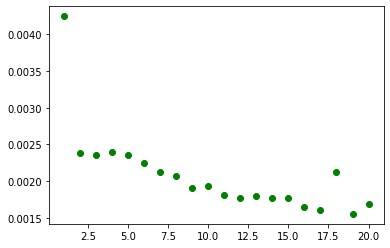

In [21]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [22]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0489

Test Accuracy: 0.94


**Case 4:**

Change Batch Size(HyperParameter Optimization) and try to regularize the objective function by applying l2 penalty/regularization. Since the codebase is huge because of the model running in different config, I am only going to implement the mlp on cpu function and not mlp on other modes.

In [23]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)) + tf.reduce_sum(tf.square(self.W4)))/4
      current_loss = self.loss(predicted, y_train) + 0.001 * L2
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    #output = tf.nn.softmax(output)
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


Train Accuracy: 0.9220
Number of Epoch = 1 - Average Cross Entropy:= 0.0038350042724609374 

Validation Accuracy: 0.9326

Train Accuracy: 0.9362
Number of Epoch = 2 - Average Cross Entropy:= 0.001669705352783203 

Validation Accuracy: 0.9415

Train Accuracy: 0.9567
Number of Epoch = 3 - Average Cross Entropy:= 0.001267484130859375 

Validation Accuracy: 0.9568

Train Accuracy: 0.9614
Number of Epoch = 4 - Average Cross Entropy:= 0.0010321977233886718 

Validation Accuracy: 0.9597

Train Accuracy: 0.9672
Number of Epoch = 5 - Average Cross Entropy:= 0.0008803965759277344 

Validation Accuracy: 0.9625

Train Accuracy: 0.9720
Number of Epoch = 6 - Average Cross Entropy:= 0.00076451171875 

Validation Accuracy: 0.9666

Train Accuracy: 0.9729
Number of Epoch = 7 - Average Cross Entropy:= 0.0006625321197509766 

Validation Accuracy: 0.9673

Train Accuracy: 0.9784
Number of Epoch = 8 - Average Cross Entropy:= 0.0005917183303833008 

Validation Accuracy: 0.9709

Train Accuracy: 0.9796
Number 

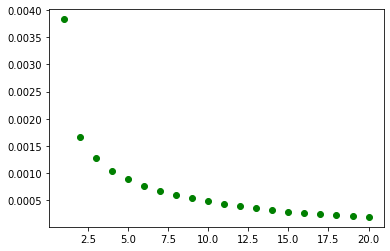

In [24]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [25]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0216

Test Accuracy: 0.97


**Case 5:**

Change Batch Size(HyperParameter Optimization) and try to regularize the objective function by applying a combination of l1 and l2 penalty/regularization[Elastic Net Regularization].Dropout regularization from Keras. Since the codebase is huge because of the model running in different config, I am only going to implement the mlp on default function and not mlp on other modes.

In [26]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      L1 = (tf.reduce_sum(tf.math.abs(self.W1))+ tf.reduce_sum(tf.math.abs(self.W2))+tf.reduce_sum(tf.math.abs(self.W3)) + tf.reduce_sum(tf.math.abs(self.W4)))
      L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)) + tf.reduce_sum(tf.square(self.W4)))/4
      current_loss = self.loss(predicted, y_train) + 0.001 * L1 + 0.005 * L2
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    #output = tf.nn.softmax(output)
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


Train Accuracy: 0.8917
Number of Epoch = 1 - Average Cross Entropy:= 0.004333890075683594 

Validation Accuracy: 0.9019

Train Accuracy: 0.8892
Number of Epoch = 2 - Average Cross Entropy:= 0.002708355712890625 

Validation Accuracy: 0.9025

Train Accuracy: 0.8918
Number of Epoch = 3 - Average Cross Entropy:= 0.0026907125854492187 

Validation Accuracy: 0.9040

Train Accuracy: 0.9015
Number of Epoch = 4 - Average Cross Entropy:= 0.0026328494262695314 

Validation Accuracy: 0.9159

Train Accuracy: 0.9151
Number of Epoch = 5 - Average Cross Entropy:= 0.002466947326660156 

Validation Accuracy: 0.9262

Train Accuracy: 0.9084
Number of Epoch = 6 - Average Cross Entropy:= 0.0023447299194335938 

Validation Accuracy: 0.9156

Train Accuracy: 0.8965
Number of Epoch = 7 - Average Cross Entropy:= 0.0022092112731933594 

Validation Accuracy: 0.9068

Train Accuracy: 0.9276
Number of Epoch = 8 - Average Cross Entropy:= 0.0021363755798339845 

Validation Accuracy: 0.9327

Train Accuracy: 0.9332
Num

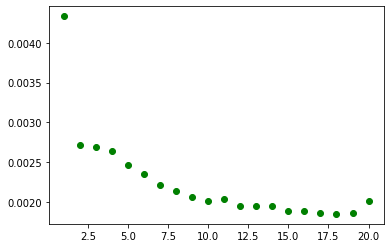

In [27]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [28]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0567

Test Accuracy: 0.94


**Case 6:**

Hyper Parameter Optimization for Batch Size using Trial and Error

In [29]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    #output = tf.nn.softmax(output)
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


Train Accuracy: 0.8747
Number of Epoch = 1 - Average Cross Entropy:= 0.002527323760986328 

Validation Accuracy: 0.8905

Train Accuracy: 0.8987
Number of Epoch = 2 - Average Cross Entropy:= 0.0011094089508056641 

Validation Accuracy: 0.9082

Train Accuracy: 0.9402
Number of Epoch = 3 - Average Cross Entropy:= 0.0008683643341064454 

Validation Accuracy: 0.9435

Train Accuracy: 0.9444
Number of Epoch = 4 - Average Cross Entropy:= 0.0007290935516357422 

Validation Accuracy: 0.9491

Train Accuracy: 0.9567
Number of Epoch = 5 - Average Cross Entropy:= 0.0006308089065551758 

Validation Accuracy: 0.9562

Train Accuracy: 0.9581
Number of Epoch = 6 - Average Cross Entropy:= 0.0005490301513671875 

Validation Accuracy: 0.9579

Train Accuracy: 0.9647
Number of Epoch = 7 - Average Cross Entropy:= 0.0004911091232299805 

Validation Accuracy: 0.9610

Train Accuracy: 0.9698
Number of Epoch = 8 - Average Cross Entropy:= 0.00043653514862060545 

Validation Accuracy: 0.9651

Train Accuracy: 0.9724


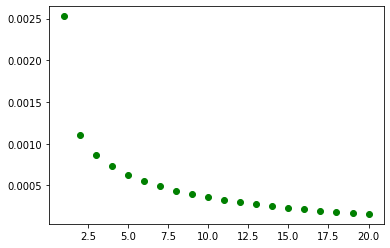

In [30]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(256) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [31]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0230

Test Accuracy: 0.97



Train Accuracy: 0.9429
Number of Epoch = 1 - Average Cross Entropy:= 0.005788213500976563 

Validation Accuracy: 0.9468

Train Accuracy: 0.9630
Number of Epoch = 2 - Average Cross Entropy:= 0.00248618408203125 

Validation Accuracy: 0.9602

Train Accuracy: 0.9695
Number of Epoch = 3 - Average Cross Entropy:= 0.0017873818969726563 

Validation Accuracy: 0.9636

Train Accuracy: 0.9748
Number of Epoch = 4 - Average Cross Entropy:= 0.0013688674926757812 

Validation Accuracy: 0.9661

Train Accuracy: 0.9802
Number of Epoch = 5 - Average Cross Entropy:= 0.0011215206146240235 

Validation Accuracy: 0.9693

Train Accuracy: 0.9729
Number of Epoch = 6 - Average Cross Entropy:= 0.0008883085632324218 

Validation Accuracy: 0.9626

Train Accuracy: 0.9825
Number of Epoch = 7 - Average Cross Entropy:= 0.0007283372497558593 

Validation Accuracy: 0.9676

Train Accuracy: 0.9879
Number of Epoch = 8 - Average Cross Entropy:= 0.0005836821365356445 

Validation Accuracy: 0.9719

Train Accuracy: 0.9863
Num

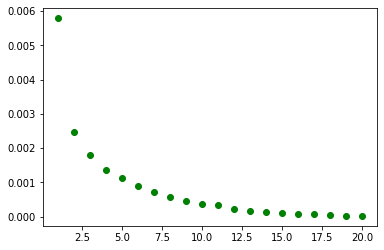

In [32]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(64) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [33]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0281

Test Accuracy: 0.98


**Case 7:**

Hyper Parameter Optimization for Learning Rate using Trial and Error

In [34]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    #output = tf.nn.softmax(output)
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


Train Accuracy: 0.0847
Number of Epoch = 1 - Average Cross Entropy:= 0.018395963134765624 

Validation Accuracy: 0.0850

Train Accuracy: 0.1125
Number of Epoch = 2 - Average Cross Entropy:= 0.01797009765625 

Validation Accuracy: 0.1138

Train Accuracy: 0.1448
Number of Epoch = 3 - Average Cross Entropy:= 0.0176326904296875 

Validation Accuracy: 0.1459

Train Accuracy: 0.1804
Number of Epoch = 4 - Average Cross Entropy:= 0.01734888916015625 

Validation Accuracy: 0.1782

Train Accuracy: 0.2187
Number of Epoch = 5 - Average Cross Entropy:= 0.017098427734375 

Validation Accuracy: 0.2193

Train Accuracy: 0.2575
Number of Epoch = 6 - Average Cross Entropy:= 0.016869842529296877 

Validation Accuracy: 0.2651

Train Accuracy: 0.2934
Number of Epoch = 7 - Average Cross Entropy:= 0.01665509521484375 

Validation Accuracy: 0.3019

Train Accuracy: 0.3268
Number of Epoch = 8 - Average Cross Entropy:= 0.016449498291015625 

Validation Accuracy: 0.3364

Train Accuracy: 0.3568
Number of Epoch = 9

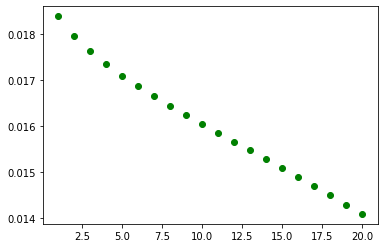

In [35]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [36]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.4430

Test Accuracy: 0.55


In [37]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    #output = tf.nn.softmax(output)
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


Train Accuracy: 0.3558
Number of Epoch = 1 - Average Cross Entropy:= 0.017294365234375 

Validation Accuracy: 0.3572

Train Accuracy: 0.4936
Number of Epoch = 2 - Average Cross Entropy:= 0.015393995361328124 

Validation Accuracy: 0.5024

Train Accuracy: 0.5843
Number of Epoch = 3 - Average Cross Entropy:= 0.01348860107421875 

Validation Accuracy: 0.5983

Train Accuracy: 0.6514
Number of Epoch = 4 - Average Cross Entropy:= 0.011526802978515625 

Validation Accuracy: 0.6687

Train Accuracy: 0.6990
Number of Epoch = 5 - Average Cross Entropy:= 0.0097697412109375 

Validation Accuracy: 0.7229

Train Accuracy: 0.7337
Number of Epoch = 6 - Average Cross Entropy:= 0.008374005126953125 

Validation Accuracy: 0.7646

Train Accuracy: 0.7591
Number of Epoch = 7 - Average Cross Entropy:= 0.007326719360351563 

Validation Accuracy: 0.7913

Train Accuracy: 0.7803
Number of Epoch = 8 - Average Cross Entropy:= 0.00653896240234375 

Validation Accuracy: 0.8078

Train Accuracy: 0.7966
Number of Epoch

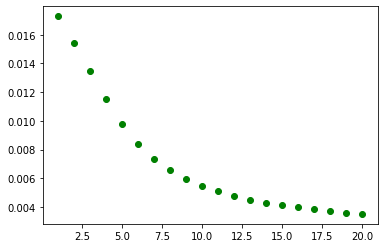

In [38]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [39]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.1032

Test Accuracy: 0.88


**Case 8:**

Hyper Parameter Optimisation for Activation Function using Trial and Error

In [40]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    #output = tf.nn.softmax(output)
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


Train Accuracy: 0.8717
Number of Epoch = 1 - Average Cross Entropy:= 0.008604240112304687 

Validation Accuracy: 0.8861

Train Accuracy: 0.9062
Number of Epoch = 2 - Average Cross Entropy:= 0.0029692794799804686 

Validation Accuracy: 0.9179

Train Accuracy: 0.9212
Number of Epoch = 3 - Average Cross Entropy:= 0.0023196597290039062 

Validation Accuracy: 0.9306

Train Accuracy: 0.9310
Number of Epoch = 4 - Average Cross Entropy:= 0.0020050076293945313 

Validation Accuracy: 0.9364

Train Accuracy: 0.9370
Number of Epoch = 5 - Average Cross Entropy:= 0.0017959553527832032 

Validation Accuracy: 0.9421

Train Accuracy: 0.9426
Number of Epoch = 6 - Average Cross Entropy:= 0.0016393472290039063 

Validation Accuracy: 0.9463

Train Accuracy: 0.9467
Number of Epoch = 7 - Average Cross Entropy:= 0.0015134660339355469 

Validation Accuracy: 0.9504

Train Accuracy: 0.9493
Number of Epoch = 8 - Average Cross Entropy:= 0.0014115592956542968 

Validation Accuracy: 0.9542

Train Accuracy: 0.9528
N

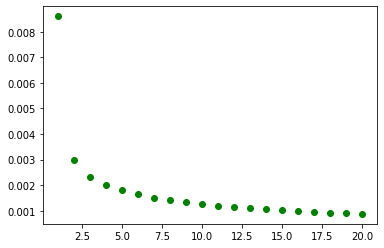

In [41]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [42]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0342

Test Accuracy: 0.96


In [43]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adagrad(learning_rate = 1e-4)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    #output = tf.nn.softmax(output)
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


Train Accuracy: 0.1631
Number of Epoch = 1 - Average Cross Entropy:= 0.018111458740234374 

Validation Accuracy: 0.1659

Train Accuracy: 0.2163
Number of Epoch = 2 - Average Cross Entropy:= 0.017578458251953127 

Validation Accuracy: 0.2198

Train Accuracy: 0.2725
Number of Epoch = 3 - Average Cross Entropy:= 0.017096158447265624 

Validation Accuracy: 0.2784

Train Accuracy: 0.3312
Number of Epoch = 4 - Average Cross Entropy:= 0.016625494384765627 

Validation Accuracy: 0.3398

Train Accuracy: 0.3979
Number of Epoch = 5 - Average Cross Entropy:= 0.01614898193359375 

Validation Accuracy: 0.4081

Train Accuracy: 0.4662
Number of Epoch = 6 - Average Cross Entropy:= 0.01565573486328125 

Validation Accuracy: 0.4818

Train Accuracy: 0.5199
Number of Epoch = 7 - Average Cross Entropy:= 0.01514045654296875 

Validation Accuracy: 0.5369

Train Accuracy: 0.5573
Number of Epoch = 8 - Average Cross Entropy:= 0.014600836181640625 

Validation Accuracy: 0.5788

Train Accuracy: 0.5852
Number of E

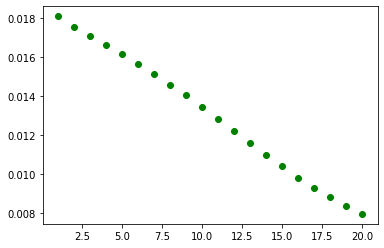

In [44]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [45]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.2370

Test Accuracy: 0.77


**Case 9:**

Best Model HyperParameters: Model = cpu, LR = 0.1, Optimizer = SGD, Batch Size = 128 or 256(Same Acc), Regularization = Dropout,L2 or No Reg(Same Accuracy)

In [46]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)) + tf.reduce_sum(tf.square(self.W4)))/4
      current_loss = self.loss(predicted, y_train) + 0.001 * L2
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    #output = tf.nn.softmax(output)
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


Train Accuracy: 0.9130
Number of Epoch = 1 - Average Cross Entropy:= 0.00398046630859375 

Validation Accuracy: 0.9221

Train Accuracy: 0.9298
Number of Epoch = 2 - Average Cross Entropy:= 0.0017332978820800782 

Validation Accuracy: 0.9344

Train Accuracy: 0.9547
Number of Epoch = 3 - Average Cross Entropy:= 0.0013069447326660155 

Validation Accuracy: 0.9538

Train Accuracy: 0.9577
Number of Epoch = 4 - Average Cross Entropy:= 0.0010562254333496093 

Validation Accuracy: 0.9561

Train Accuracy: 0.9665
Number of Epoch = 5 - Average Cross Entropy:= 0.0008960999298095703 

Validation Accuracy: 0.9612

Train Accuracy: 0.9689
Number of Epoch = 6 - Average Cross Entropy:= 0.0007759777069091797 

Validation Accuracy: 0.9633

Train Accuracy: 0.9736
Number of Epoch = 7 - Average Cross Entropy:= 0.0006639466094970703 

Validation Accuracy: 0.9650

Train Accuracy: 0.9769
Number of Epoch = 8 - Average Cross Entropy:= 0.0005919917678833008 

Validation Accuracy: 0.9688

Train Accuracy: 0.9795
Nu

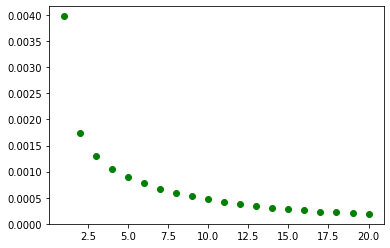

In [47]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128) #seed same as emailID number
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [48]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0204

Test Accuracy: 0.98


**TEST ACCURACY HAS INCREASED BY 0.01 FROM 0.97, thanks to these measures.**